In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.nn import Sequential, ReLU, Module, Dropout, Sigmoid, Linear, BatchNorm2d
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
from torch.nn.functional import cross_entropy
from sklearn.metrics import accuracy_score

In [1]:
import torch

In [2]:
if (torch.cuda.is_available()):
    print("CUDA is available")
    device = 'cuda'
else:
    print("CUDA is not available")
    device = 'cpu'

device = torch.device(device)
device

CUDA is available


device(type='cuda')

In [102]:
data = pd.read_excel('../Lab-1/DryBeanDataset/Dry_Bean_Dataset.xlsx')
data.head(5)

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


## Data Preprocessing

In [103]:
from sklearn.preprocessing import StandardScaler

X = data.iloc[:,:-1]
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X)
X.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.840749,-1.143319,-1.306598,-0.631153,-1.565053,-2.185720,-0.841451,-1.063341,0.289087,0.367613,1.423867,1.839116,0.680786,2.402173,1.925723,0.838371
1,-0.829188,-1.013924,-1.395911,-0.434445,-1.969784,-3.686040,-0.826102,-1.044217,0.697477,-0.462907,0.231054,2.495449,0.367967,3.100893,2.689702,0.771138
2,-0.807157,-1.078829,-1.252357,-0.585735,-1.514291,-2.045336,-0.808704,-1.008084,0.578195,0.518417,1.252865,1.764843,0.603129,2.235091,1.841356,0.916755
3,-0.785741,-0.977215,-1.278825,-0.439290,-1.741618,-2.742211,-0.773975,-0.973337,0.671260,-2.241767,0.515049,2.081715,0.401718,2.515075,2.204250,-0.197985
4,-0.781239,-1.097384,-1.380471,-0.266663,-2.117993,-4.535028,-0.784286,-0.966080,0.476020,0.804772,1.874992,2.765330,0.118268,3.270983,3.013462,0.939640


In [104]:
from sklearn.preprocessing import LabelEncoder

Y = data.iloc[:,-1]
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
Y = pd.DataFrame(Y)
Y.head(5)

,0
0,5
1,5
2,5
3,5
4,5


## MLP

In [105]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(11569, 16) (2042, 16) (11569, 1) (2042, 1)


In [106]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x.astype(np.float32))
        self.y = torch.tensor(y)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
train_dataset = Dataset(X_train.to_numpy().astype('float32'), Y_train.to_numpy().astype('float32'))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = Dataset(X_test.to_numpy().astype('float32'), Y_test.to_numpy().astype('float32'))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [107]:
class Net(nn.Module):
    def __init__(self, hidden_size1):
        super().__init__()
        self.fc1 = nn.Linear(16, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, 7)
        self.hidden_size1 = hidden_size1
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # print(x)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.softmax(out)
        # print(out)
        return out

In [108]:
model = Net(16)
model = model.to(device)
loss_function = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 100

all_train_losses = []
all_val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):

    model.train(True)
    running_train_loss = 0.0

    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        y = nn.functional.one_hot(y.to(torch.int64), num_classes=7).to(torch.float32).reshape(-1,7).to(device)
        y_pred = model(x)

        loss = loss_function(y_pred, y)
        running_train_loss += loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    train_loss = running_train_loss / len(train_loader)
    all_train_losses.append(train_loss)
    train_accuracies.append(accuracy_score(torch.argmax(y_pred, dim=1).cpu(), torch.argmax(y, dim=1).cpu()))

    print(f'Epoch {epoch}')
    print(f'Training loss: {train_loss} Train accuracy: {accuracy_score(torch.argmax(y_pred, dim=1).cpu(), torch.argmax(y, dim=1).cpu())}')

    model.train(False)
    running_val_loss = 0.0
    for i, (x, y) in enumerate(test_loader):
        x, y = x.to(device), y.to(device)
        y = nn.functional.one_hot(y.to(torch.int64), num_classes=7).to(torch.float32).reshape(-1,7).to(device)
        y_pred = model(x)
        loss = loss_function(y_pred, y)
        running_val_loss += loss.item()

    val_loss = running_val_loss / len(test_loader)
    all_val_losses.append(val_loss)
    val_accuracies.append(accuracy_score(torch.argmax(y_pred, dim=1).cpu(), torch.argmax(y, dim=1).cpu()))

    print(f'Validation loss: {val_loss} Validation accuracy: {accuracy_score(torch.argmax(y_pred, dim=1).cpu(), torch.argmax(y, dim=1).cpu())}')
    print('--------------------------------------------------------------')

Epoch 0
Training loss: 1.3356568951633094 Train accuracy: 1.0
Validation loss: 1.2544938828796148 Validation accuracy: 0.8846153846153846
--------------------------------------------------------------
Epoch 1
Training loss: 1.2515060144234758 Train accuracy: 0.9411764705882353
Validation loss: 1.2473998107016087 Validation accuracy: 0.8846153846153846
--------------------------------------------------------------
Epoch 2
Training loss: 1.2480370698712808 Train accuracy: 0.8235294117647058
Validation loss: 1.244925832375884 Validation accuracy: 0.9615384615384616
--------------------------------------------------------------
Epoch 3
Training loss: 1.244634663202486 Train accuracy: 0.9411764705882353
Validation loss: 1.2517324779182673 Validation accuracy: 0.8461538461538461
--------------------------------------------------------------
Epoch 4
Training loss: 1.2449074068122148 Train accuracy: 0.8823529411764706
Validation loss: 1.2392325531691313 Validation accuracy: 0.9230769230769231


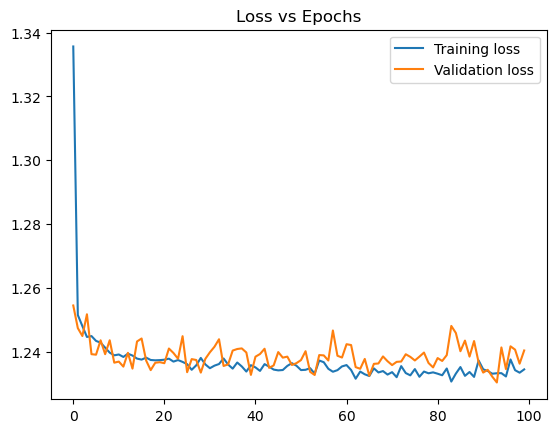

In [109]:
plt.plot(all_train_losses, label='Training loss')
plt.plot(all_val_losses, label='Validation loss')
plt.legend()
plt.title('Loss vs Epochs')
plt.show()

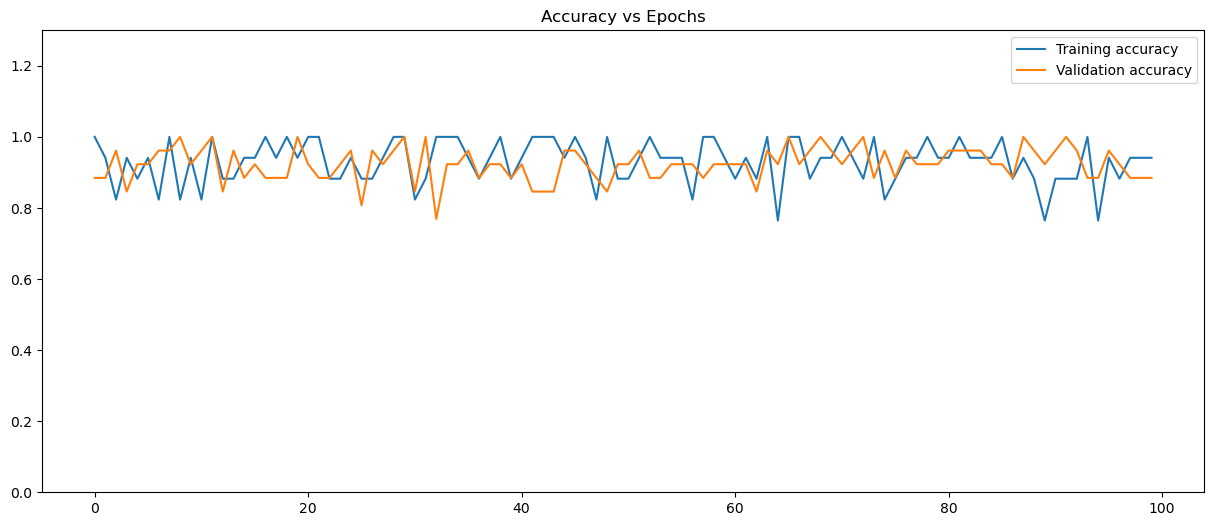

In [110]:
plt.figure(figsize=(15,6))
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(val_accuracies, label='Validation accuracy')
plt.legend()
plt.ylim(0, 1.3)
plt.title('Accuracy vs Epochs')
plt.show()